In [1]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline
%precision 5
from pdb import set_trace as keyboard

## Boundary value problem

Consider a square domain $(x,y)\in \Omega = [0, 1]\times [0,1]$. At the left boundary consider $\theta=0$. On the top and bottom, we have $\mathbf{q}\cdot\mathbf{n} = 0$ and on the right, $\mathbf{q}\cdot\mathbf{n} = -2$ (implying flux entering the domain). There is a source term $s(\theta) = -6\theta$ (implying a heat sink), and the conductivity is $k(\theta)=\theta$. The problem is find $\theta \in \Omega$ such that

$-\nabla_x (k(\theta) \nabla_x \theta) = s(\theta) \in \Omega$

with the boundary conditions specified above. Note that this is a nonlinear problem.

### Weak form

The weak form (after transferring everything to one side) of this problem leads to the following integral that needs to be calculated for every element

$-\int_{\Omega^e} \mathbf{q}\cdot \nabla_x w\,  d\Omega^e - \int_{\Omega^e} s\, w \, d\Omega^e - \int_{\Gamma^e} q_n\, w \, d\Gamma^e$

where $q_n = \mathbf{q}\cdot\mathbf{n}$, $\mathbf{q} = -k\nabla_x \theta$ is the flux, which depends on the unknown scalar field $\theta$, and $s$ is the source term. The weight function is $w$. Note that the Neumann BC term is only included for the elements with a non--zero flux value $q_n$ that have a boundary on $\Gamma_n$ or the part where natural boundary conditions are specified.

## Mesh

Consider a simple cartesian mesh made out of 64 quadrilateral elements and 81 nodes. For simplicity, we arrange the nodes such that the ones with the Dirichlet BC appear first in the list.

In [13]:
# Define the number of nodes and elements
n_node = 81
n_elem = 64

# Initialize the node and element arrays
node_x = np.zeros((n_node, 2))
elements = np.zeros((n_elem, 4), dtype=int)

# Fill the node array
for i in range(9):
    for j in range(9):
        node_x[j*9 + i] = [j*0.125, i*0.125]

print("Nodes array:")
print(node_x)


# Fill the element array
for i in range(8):
    for j in range(8):
        elements[j + i*8] = [i + j*9, i + 1 + j*9, i + 10 + j*9, i + 9 + j*9]
print("\nElements array:")
print(elements)

Nodes array:
[[0.    0.   ]
 [0.    0.125]
 [0.    0.25 ]
 [0.    0.375]
 [0.    0.5  ]
 [0.    0.625]
 [0.    0.75 ]
 [0.    0.875]
 [0.    1.   ]
 [0.125 0.   ]
 [0.125 0.125]
 [0.125 0.25 ]
 [0.125 0.375]
 [0.125 0.5  ]
 [0.125 0.625]
 [0.125 0.75 ]
 [0.125 0.875]
 [0.125 1.   ]
 [0.25  0.   ]
 [0.25  0.125]
 [0.25  0.25 ]
 [0.25  0.375]
 [0.25  0.5  ]
 [0.25  0.625]
 [0.25  0.75 ]
 [0.25  0.875]
 [0.25  1.   ]
 [0.375 0.   ]
 [0.375 0.125]
 [0.375 0.25 ]
 [0.375 0.375]
 [0.375 0.5  ]
 [0.375 0.625]
 [0.375 0.75 ]
 [0.375 0.875]
 [0.375 1.   ]
 [0.5   0.   ]
 [0.5   0.125]
 [0.5   0.25 ]
 [0.5   0.375]
 [0.5   0.5  ]
 [0.5   0.625]
 [0.5   0.75 ]
 [0.5   0.875]
 [0.5   1.   ]
 [0.625 0.   ]
 [0.625 0.125]
 [0.625 0.25 ]
 [0.625 0.375]
 [0.625 0.5  ]
 [0.625 0.625]
 [0.625 0.75 ]
 [0.625 0.875]
 [0.625 1.   ]
 [0.75  0.   ]
 [0.75  0.125]
 [0.75  0.25 ]
 [0.75  0.375]
 [0.75  0.5  ]
 [0.75  0.625]
 [0.75  0.75 ]
 [0.75  0.875]
 [0.75  1.   ]
 [0.875 0.   ]
 [0.875 0.125]
 [0.875 0.25

## PLOT THE MESH

To visualize the mesh and the elements, we plot the mesh with node numbers at each node

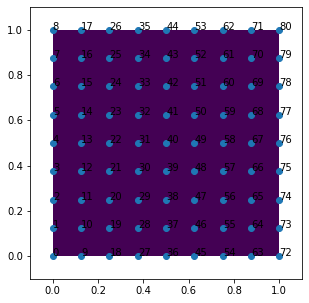

In [14]:
f, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(5,5))
ax1.set_xlim([-0.1, 1.1])
ax1.set_ylim([-0.1, 1.1])
ax1.set_aspect('equal')
patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = 0.0
p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)
ax1.scatter(node_x[:,0],node_x[:,1])
for i, txt in enumerate(node_x[:,0]):
    ax1.annotate(i, (node_x[i,0], node_x[i,1]))

Since the problem also involves non-zero flux BCs, the best strategy is to add a mesh for boundary where flux BCs are imposed. This information includes number of boundary elements where the flux BC is imposed, the order node pairs (2D) for each face and the nodal flux values.

Note: If one were to rigorously write out the explicit boundary term in terms of the 2D shape functions, the resulting simplifications resullt in an expression that is analogous to considering separate 1D shape functions on the edge.

In [16]:
# Define the number of boundary elements
n_boundary_e = 8

# Initialize the boundary elements array
boundary_elements = np.zeros((n_boundary_e, 2), dtype=int)

# Fill the boundary elements array
for i in range(8):
    boundary_elements[i] = [i+72, i+73]

print("Boundary elements array:")
print(boundary_elements)


# create the flux over the nodes
node_qn = np.array([[-2.0, -2.0]] * n_boundary_e)

Boundary elements array:
[[72 73]
 [73 74]
 [74 75]
 [75 76]
 [76 77]
 [77 78]
 [78 79]
 [79 80]]


### Residual

This integral, upon introducing the discrete weight function $w^h = \sum_{i=1}^4 N_i^e w_i^e$ and taking the nodal values of the weight function $w_i^e$ out of the integral, leads to the residual vector

$R^e_a = -\int_{\Omega^e} \mathbf{q}(\theta^h) \cdot \nabla_x N_a^e \, d\Omega^e - \int_{\Omega^e} s(\theta^h) N_a^e \, d\Omega^e - \int_{\Gamma^e} q_n\, N_a^e \, d\Gamma^e$

For the elements specified above, the residual is calculated for each node $a=1,2,3,4$. As mentioned earlier, the flux term is not included for interior elements or for elements which dont have a boundary on $\Gamma_n$.

### Tangent


Linearization of the residual in the direction of the increment $\Delta \theta$ and substitution of the discrete increment leads to the tangent matrix $\mathbf{K}^e$ for the element, which is the $4\times 4$ matrix needed for the Newton-Raphson iterations as will be seen in this notebook

$K_{ab}^e = \int_{\Omega^e} \left(-\frac{d \, k(\theta)}{d\, \theta}\, N_b^e \, \nabla_x\theta \cdot \nabla_x N_a^e \right)d\Omega^e + \int_{\Omega^e} -k(\theta) \nabla_x N_b^e \cdot \nabla_x N_a^e d\Omega^e  - \int_{\Omega^e} \left(\frac{d\, s(\theta)}{d\, \theta}\, N_b^e \, N_a^e \right) d\Omega^e $

## Newton Raphson solution

We start with a guess for the solution, which has to satisfy the essential boundary conditions. Since this is a nonlinear problem, initial conditions dictate the fina steady state solution. For demonstration, we consider a temperature field $\theta =  x^2$ everywhere else except the edge with Dirichlet BCs.

In [17]:
# First guess for the Newton Raphson algorithm, remember it needs to satisfy the essential boundary conditions
# here, the only essential boundary condition is theta=0 on the bottom end. We need to initialize other nodal values to non-zero temperatures.

node_th = np.zeros((n_node))
for ni in range(n_node):
    if node_x[ni,0]>0.001:
        node_th[ni] = node_x[ni,0]**2

We define the shape functions on the 2D bi-unit domain, along with the derivatives. An additional set of 1D elements is also defined to accunt for the non-zero flux.

In [18]:
# Definition of the shape function and the derivative with respect to parent domain xi

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

# For the flux use 1D functions
def N1D(xi):
    return 0.5*np.array([(1-xi),(1+xi)])

def dN1Ddxi(xi):
    return 0.5*np.array([-1.0,1.0])

For each iteration of the Newton Raphson, the total residual and total tangent are needed. For that, a loop over the elements of the mesh is done. Inside of this loop, the residual and tangent for an individual element is calculated and then *assembled* into the global residual and tangent. The residual and tangent are used to compute the increment. The increment is used to update our guess. The Newton-Loop continues until convergence.

In [19]:
#----------------------#
# NEWTON LOOP
#----------------------#
res = 1
iter = 0
itermax = 100
tol = 1e-10
while res>tol and iter<itermax:
    # INITIALIZE GLOBAL RESIDUAL AND TANGENT
    RR = np.zeros((n_node))
    KK = np.zeros((n_node,n_node))
    #----------------------#
    # LOOP OVER ELEMENTS
    #----------------------#
    for ei in range(n_elem):
        # node coordinates
        node_ei = elements[ei]
        x1e = node_x[node_ei[0]]
        x2e = node_x[node_ei[1]]
        x3e = node_x[node_ei[2]]
        x4e = node_x[node_ei[3]]
        # nodal values for the field theta
        th1e = node_th[node_ei[0]]
        th2e = node_th[node_ei[1]]
        th3e = node_th[node_ei[2]]
        th4e = node_th[node_ei[3]]
        #------------------------------#
        # LOOP OVER INTEGRATION POINTS
        #------------------------------#
        # integration points (using 2x2 Gauss quadrature in the parent domain)
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                              [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        # Initialize the ELEMENT residual to a vector of zeros
        Re = np.zeros((4)) # note the size of the residual is the number of nodes
        # Initialize the ELEMENT tangent to a matrix of zeros
        Ke = np.zeros((4,4))
        # this is where the actual loop starts
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wip = IP_wi[ip]
            # evaluate the isoparametric map
            Ns = Nvec(xi,eta)
            x = Ns[0]*x1e + Ns[1]*x2e + Ns[2]*x3e + Ns[3]*x4e
            # evaluate the Jacobian
            dNsdxi = dNvecdxi(xi,eta)
            dxdxi = np.outer(x1e,dNsdxi[:,0])+np.outer(x2e,dNsdxi[:,1])+np.outer(x3e,dNsdxi[:,2])+np.outer(x4e,dNsdxi[:,3])
            # get gradient of basis function with respect to x using inverse jacobian. Note that the inverse is not taken explicitly.
            # Rather, the linear system is solved using numpy.linalg.solve
            dNsdx = np.linalg.solve(dxdxi.transpose(),dNsdxi)
            # evaluate the field theta_h at integration point
            theta = Ns[0]*th1e + Ns[1]*th2e + Ns[2]*th3e + Ns[3]*th4e
            # evaluate the gradient of theta_h with respect to coordinates x
            gradx_theta = th1e*dNsdx[:,0]+th2e*dNsdx[:,1]+th3e*dNsdx[:,2]+th4e*dNsdx[:,3]
            # evaluate the conductivity
            k = theta
            # evaluate the source
            s = -6.0*theta
            #------------------------------#
            # INTEGRATE THE RESIDUAL
            #------------------------------#
            Re[0] +=  wip*np.linalg.det(dxdxi)*(k*np.dot(gradx_theta,dNsdx[:,0]) - s*Ns[0] )
            Re[1] +=  wip*np.linalg.det(dxdxi)*(k*np.dot(gradx_theta,dNsdx[:,1]) - s*Ns[1] )
            Re[2] +=  wip*np.linalg.det(dxdxi)*(k*np.dot(gradx_theta,dNsdx[:,2]) - s*Ns[2] )
            Re[3] +=  wip*np.linalg.det(dxdxi)*(k*np.dot(gradx_theta,dNsdx[:,3]) - s*Ns[3] )

            # for the tangent a couple of derivatives needed first
            dkdtheta = 1.0
            dsdtheta = -6.0

            #------------------------------#
            # INTEGRATE THE TANGENT
            #------------------------------#
            # easier to do in two for loops, both are over the nodes, remember that the residual
            # has four entries because there are four shape functions, which we referred to N_a
            # When we did the linearization and plugged in the discrete increment we intriduced
            # additional shape functions N_b, where b=1,2,3,4 because there are four nodes
            for a in range(4):
                for b in range(4):
                    Ke[a,b] +=  wip*np.linalg.det(dxdxi)*(dkdtheta*Ns[b]*np.dot(gradx_theta,dNsdx[:,a])\
                                                          +k*np.dot(dNsdx[:,b],dNsdx[:,a]) - dsdtheta*Ns[a]*Ns[b] )
        #------------------------------#
        # ASSEMBLE INTO GLOBAL RR, KK
        #------------------------------#
        # Here again it is convenient to have a loop over nodes of the element
        for a in range(4):
            RR[node_ei[a]] += Re[a]
            for b in range(4):
                KK[node_ei[a],node_ei[b]] += Ke[a,b]

    #-------------------------------------------#
    # Fill in the flux residual
    #-------------------------------------------#
    # start with initial flux of zeros
    RRq = np.zeros((n_node))
    for ei in range(n_boundary_e):
        # node coordinates for the boundary elements
        nodes_ei = boundary_elements[ei]
        x1e = node_x[nodes_ei[0]]
        x2e = node_x[nodes_ei[1]]
        # nodal values for the flux,
        q1e = node_qn[ei,0]
        q2e = node_qn[ei,1]
        # length of the edge
        le = np.linalg.norm(x2e-x1e)
        #------------------------------#
        # LOOP OVER INTEGRATION POINTS
        #------------------------------#
        # integration points in 1D
        IP_xi = np.array([-1./np.sqrt(3),+1./np.sqrt(3)])
        IP_wi = np.array([1.,1.])
        # Initialize the ELEMENT residual to a vector of zeros
        Req = np.zeros(2) # note the size of the residual is the number of nodes
        for ip in range(2):
            xi = IP_xi[ip]
            wip = IP_wi[ip]
            qn = N1D(xi)[0]*q1e + N1D(xi)[1]*q2e
            # the corresponding Jacobian
            dsxdxi = dN1Ddxi(xi)[1]*le
            # the integral
            Req[0] -= wip*dsxdxi*qn*N1D(xi)[0]
            Req[1] -= wip*dsxdxi*qn*N1D(xi)[1]
        #------------------------------#
        # ASSEMBLE INTO GLOBAL RRq
        #------------------------------#
        RRq[nodes_ei[0]]+=Req[0]
        RRq[nodes_ei[1]]+=Req[1]
    #-------------------------------------------#
    # PARTITION, ONLY RR FROM NODES WITHOUT EBC
    #-------------------------------------------#
    RR_dof = RR[8:] + RRq[8:] # ignore the first 8 nodes which have Dirichlet BCs
    KK_dof = KK[8:,8:] # ignore the corresponding rows and columns in KK

    #------------------------------#
    # NEWTON STEP
    #------------------------------#
    res = np.linalg.norm(RR_dof)
    th_incr = np.linalg.solve(KK_dof,RR_dof)
    # note, the increment is only for nodes which are not in the EBC
    node_th[8:] -= th_incr
    iter+=1
    print('iteration %i'%iter)
    print('residual %f'%res)




iteration 1
residual 0.001801
iteration 2
residual 0.000034
iteration 3
residual 0.000000
iteration 4
residual 0.000000


## Plot

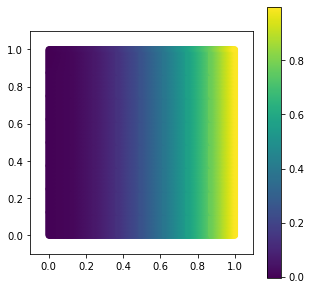

In [20]:
f, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(5,5))
ax1.set_xlim([-0.1, 1.1])
ax1.set_ylim([-0.1, 1.1])
ax1.set_aspect('equal')
patches1 = []
colors1 = np.zeros((n_elem))
theta_vec_e = []
x_vec_e = []
y_vec_e = []
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    x1e = node_x[n1]
    x2e = node_x[n2]
    x3e = node_x[n3]
    x4e = node_x[n4]
    th1e = node_th[n1]
    th2e = node_th[n2]
    th3e = node_th[n3]
    th4e = node_th[n4]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = 0.0
    # create a scatter plot by sampling over the parent domain
    theta_vec = np.zeros((900))
    x_vec = np.zeros((900,2))
    for ii in range(30):
        for jj in range(30):
            xi = -1 + ii/29.*2
            eta = -1 + jj/29.*2
            Ns = Nvec(xi,eta)
            x_vec[ii*30+jj] = Ns[0]*x1e + Ns[1]*x2e + Ns[2]*x3e + Ns[3]*x4e
            theta_vec[ii*30+jj]= Ns[0]*th1e + Ns[1]*th2e + Ns[2]*th3e + Ns[3]*th4e
    theta_vec_e.append(theta_vec)
    x_vec_e.append(x_vec[:,0])
    y_vec_e.append(x_vec[:,1])


p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)

#x_vec_all = np.stack((x_vec_e[0],x_vec_e[1],x_vec_e[2],x_vec_e[3],x_vec_e[4]))
#y_vec_all = np.stack((y_vec_e[0],y_vec_e[1],y_vec_e[2],y_vec_e[3],y_vec_e[4]))
#th_vec_all = np.stack((theta_vec_e[0],theta_vec_e[1],theta_vec_e[2],theta_vec_e[3],theta_vec_e[4]))

x_vec_all = np.stack(x_vec_e)
y_vec_all = np.stack(y_vec_e)
th_vec_all = np.stack(theta_vec_e)

sc = ax1.scatter(x_vec_all,y_vec_all,c=th_vec_all,s=30)
plt.colorbar(sc,ax=ax1)